In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update path for Kaggle environment)
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names to remove leading/trailing whitespace
df.columns = df.columns.str.strip()

# Ensure target column exists
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Stratified split: 80% train, 20% test
train_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["Humanitarian_Class"], random_state=42
)

# Save splits to CSV in current working directory
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# Structured summary table
split_summary = pd.DataFrame({
    "Train (80%)": train_df["Humanitarian_Class"].value_counts(),
    "Test (20%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

# Save summary table
split_summary.to_csv("/kaggle/working/split_summary.csv")

# Print result
print("✅ Data split (80/20) completed and saved as CSV files in /kaggle/working.")


✅ Data split (80/20) completed and saved as CSV files in /kaggle/working.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  47.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  47.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  46.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.0min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.1min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth

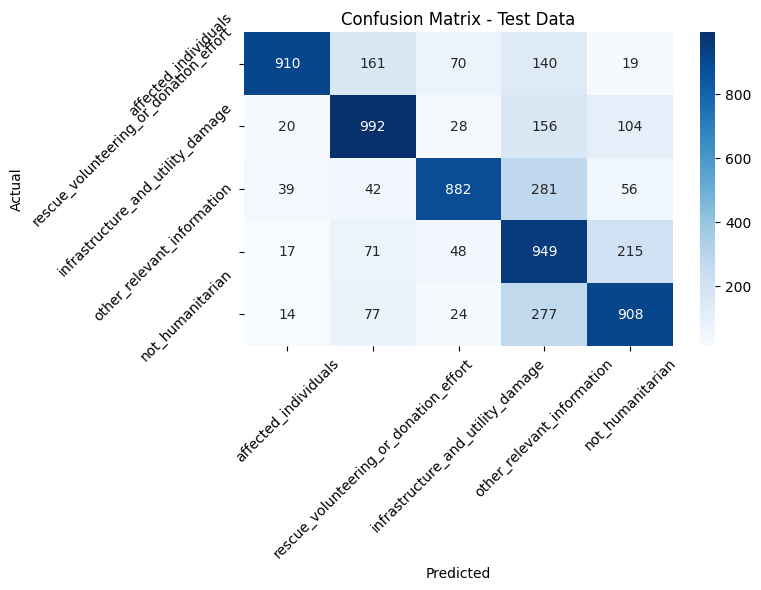

In [13]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Load training and test data
train_df = pd.read_csv("/kaggle/working/train_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# Normalize column names
for df in [train_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()

# Label mapping
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# Preprocess labels
for df in [train_df, test_df]:
    df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

y_train = train_df['humanitarian_class'].map(label_map).astype(int)
y_test = test_df['humanitarian_class'].map(label_map).astype(int)

# Fill missing text
train_df['processed_data'] = train_df['processed_data'].fillna("")
test_df['processed_data'] = test_df['processed_data'].fillna("")

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_text = vectorizer.fit_transform(train_df['processed_data'])
X_test_text = vectorizer.transform(test_df['processed_data'])

# Handcrafted Features
for df in [train_df, test_df]:
    df['tweet_length'] = df['processed_data'].apply(len)
    df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
    df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_test_num = scaler.transform(test_df[['tweet_length', 'num_hashtags', 'num_mentions']])

# Combine features
X_train_combined = np.hstack((X_train_text.toarray(), X_train_num))
X_test_combined = np.hstack((X_test_text.toarray(), X_test_num))

# Apply SMOTE to both training and test sets
max_train_samples = max(Counter(y_train).values())
max_test_samples = max(Counter(y_test).values())

smote_train = SMOTE(sampling_strategy={label: max_train_samples for label in np.unique(y_train)},
                    k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote_train.fit_resample(X_train_combined, y_train)

smote_test = SMOTE(sampling_strategy={label: max_test_samples for label in np.unique(y_test)},
                   k_neighbors=3, random_state=42)
X_test_resampled, y_test_resampled = smote_test.fit_resample(X_test_combined, y_test)

# Hyperparameter tuning
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3,
                                   scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = random_search.best_estimator_
print("Best RandomForest Parameters:", random_search.best_params_)

# Fit on full train data
best_rf.fit(X_train_resampled, y_train_resampled)

# Save model
joblib.dump(best_rf, "/kaggle/working/random_forest_best.pkl")
print("RandomForest model saved as 'random_forest_best.pkl'.")

# Predict
y_pred = best_rf.predict(X_test_resampled)

# Evaluation
acc = accuracy_score(y_test_resampled, y_pred)
report = classification_report(y_test_resampled, y_pred, target_names=label_map.keys())
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test_resampled, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Data")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
